# Import Libraries

In [1]:
# Import the pandas library for data manipulation and analysis
import pandas as pd

c:\Users\PorallaPradhyumna\.conda\envs\env_rl\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\PorallaPradhyumna\.conda\envs\env_rl\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\PorallaPradhyumna\.conda\envs\env_rl\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Data Loading and Preprocessing

In [2]:
fname = "D:/Programs/DeepLearing/Stock_prize_Prediction/Data/AAPL.csv"
with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))


['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
1258


In [3]:
import numpy as np
AdjClose = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    AdjClose[i] = values[1]
    raw_data[i, :] = values[:]

In [4]:
df = pd.read_csv(fname)
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [5]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
AdjClose = df['Adj Close']

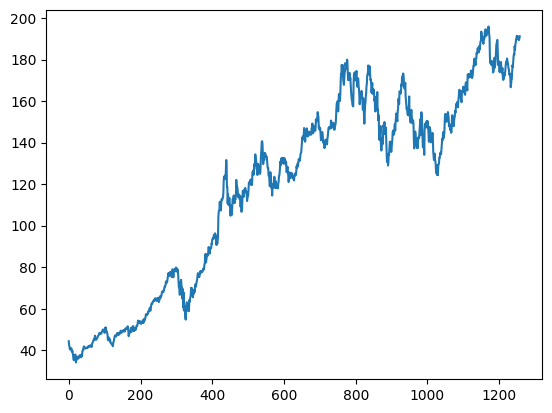

In [7]:
from matplotlib import pyplot as plt
plt.plot(range(len(AdjClose)), AdjClose)

In [8]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 629
num_val_samples: 314
num_test_samples: 315


In [9]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [10]:
raw_data.shape

(1258, 6)

In [11]:
from sklearn.preprocessing import StandardScaler

# Assuming 'y_test' is your target variable
scaler = StandardScaler()
y_test_scaled = scaler.fit_transform(AdjClose.to_numpy().reshape(-1, 1))

In [12]:
import keras
sampling_rate = 2
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=y_test_scaled[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=y_test_scaled[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=y_test_scaled[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)


In [13]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 6)
targets shape: (256, 1)


# Models and Analysis

## Dense Layers

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("v3_dense.tf",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("v3_dense.tf")



Epoch 1/10
2/2 [==============================] - 3s 628ms/step - loss: 1.4851 - mae: 1.0931 - val_loss: 12.5593 - val_mae: 3.4670
Epoch 2/10
2/2 [==============================] - 1s 527ms/step - loss: 0.7555 - mae: 0.6157 - val_loss: 4.3211 - val_mae: 2.0549
Epoch 3/10
2/2 [==============================] - 0s 338ms/step - loss: 0.2862 - mae: 0.4102 - val_loss: 0.0823 - val_mae: 0.2246
Epoch 4/10
2/2 [==============================] - 0s 57ms/step - loss: 0.1178 - mae: 0.2746 - val_loss: 0.0916 - val_mae: 0.2510
Epoch 5/10
2/2 [==============================] - 0s 44ms/step - loss: 0.0922 - mae: 0.2446 - val_loss: 0.3635 - val_mae: 0.5493
Epoch 6/10
2/2 [==============================] - 0s 38ms/step - loss: 0.0883 - mae: 0.2363 - val_loss: 0.9990 - val_mae: 0.9634
Epoch 7/10
2/2 [==============================] - 0s 39ms/step - loss: 0.0950 - mae: 0.2449 - val_loss: 2.5418 - val_mae: 1.5751
Epoch 8/10
2/2 [==============================] - 0s 36ms/step - loss: 0.1165 - mae: 0.2681 -

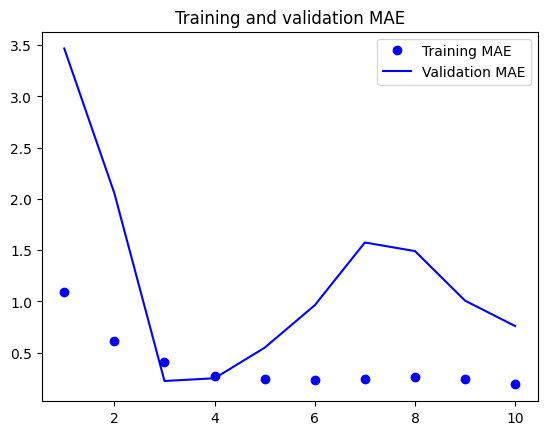

T-statistic: -2.645836049571542
P-value: 0.023660801729095546
Reject the null hypothesis. There is a significant difference between the distributions.


In [15]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

from scipy import stats


# Perform a t-test assuming unequal variances (Welch's t-test)
t_statistic, p_value = stats.ttest_ind(loss, val_loss, equal_var=False)

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the distributions.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the distributions.")


In [16]:

for samples, targets in test_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

In [17]:
(sequence_length, raw_data.shape[-1])

(120, 6)

In [18]:
output_seq_length = ((3 -  6+ 2 * 0) // 1) + 1
output_feature_channels = 8
print(output_seq_length)

-2


## Conv Layer

In [19]:
import keras
from keras import layers

# Define the model architecture
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Define callbacks, compile the model, and train
callbacks = [
    keras.callbacks.ModelCheckpoint("v3_conv.tf",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

# Load the saved model
model = keras.models.load_model("v3_conv.tf")




Epoch 1/10


2/2 [==============================] - ETA: 0s - loss: 0.3546 - mae: 0.5120

INFO:tensorflow:Assets written to: v3_conv.tf\assets


INFO:tensorflow:Assets written to: v3_conv.tf\assets


2/2 [==============================] - 7s 1s/step - loss: 0.3546 - mae: 0.5120 - val_loss: 0.7490 - val_mae: 0.8383
Epoch 2/10
2/2 [==============================] - 0s 52ms/step - loss: 0.1969 - mae: 0.3983 - val_loss: 0.7878 - val_mae: 0.8612
Epoch 3/10
1/2 [==============>...............] - ETA: 0s - loss: 0.1295 - mae: 0.3196

INFO:tensorflow:Assets written to: v3_conv.tf\assets


INFO:tensorflow:Assets written to: v3_conv.tf\assets


2/2 [==============================] - 1s 636ms/step - loss: 0.1190 - mae: 0.3009 - val_loss: 0.6201 - val_mae: 0.7581
Epoch 4/10
1/2 [==============>...............] - ETA: 0s - loss: 0.0879 - mae: 0.2476

INFO:tensorflow:Assets written to: v3_conv.tf\assets


INFO:tensorflow:Assets written to: v3_conv.tf\assets


2/2 [==============================] - 1s 673ms/step - loss: 0.0818 - mae: 0.2384 - val_loss: 0.2488 - val_mae: 0.4514
Epoch 5/10
1/2 [==============>...............] - ETA: 0s - loss: 0.0514 - mae: 0.1835

INFO:tensorflow:Assets written to: v3_conv.tf\assets


INFO:tensorflow:Assets written to: v3_conv.tf\assets


2/2 [==============================] - 1s 885ms/step - loss: 0.0521 - mae: 0.1838 - val_loss: 0.1086 - val_mae: 0.2687
Epoch 6/10
1/2 [==============>...............] - ETA: 0s - loss: 0.0356 - mae: 0.1489

INFO:tensorflow:Assets written to: v3_conv.tf\assets


INFO:tensorflow:Assets written to: v3_conv.tf\assets


2/2 [==============================] - 1s 550ms/step - loss: 0.0340 - mae: 0.1437 - val_loss: 0.0597 - val_mae: 0.1998
Epoch 7/10
1/2 [==============>...............] - ETA: 0s - loss: 0.0287 - mae: 0.1329

INFO:tensorflow:Assets written to: v3_conv.tf\assets


INFO:tensorflow:Assets written to: v3_conv.tf\assets


2/2 [==============================] - 1s 540ms/step - loss: 0.0272 - mae: 0.1291 - val_loss: 0.0470 - val_mae: 0.1770
Epoch 8/10
2/2 [==============================] - 0s 46ms/step - loss: 0.0279 - mae: 0.1329 - val_loss: 0.0470 - val_mae: 0.1770
Epoch 9/10
1/2 [==============>...............] - ETA: 0s - loss: 0.0268 - mae: 0.1258

INFO:tensorflow:Assets written to: v3_conv.tf\assets


INFO:tensorflow:Assets written to: v3_conv.tf\assets


2/2 [==============================] - 1s 530ms/step - loss: 0.0249 - mae: 0.1230 - val_loss: 0.0469 - val_mae: 0.1771
Epoch 10/10
2/2 [==============================] - 0s 42ms/step - loss: 0.0228 - mae: 0.1184 - val_loss: 0.0473 - val_mae: 0.1776


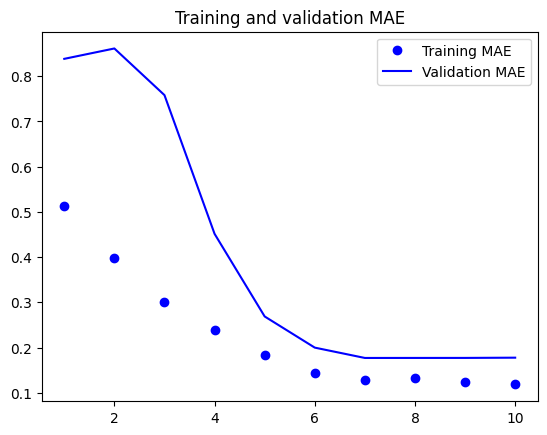

T-statistic: -1.751491540342195
P-value: 0.10410961540571043
Fail to reject the null hypothesis. There is no significant difference between the distributions.


In [20]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

from scipy import stats


# Perform a t-test assuming unequal variances (Welch's t-test)
t_statistic, p_value = stats.ttest_ind(loss, val_loss, equal_var=False)

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the distributions.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the distributions.")


## LSTM's

In [21]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("v3_lstm.tf",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("v3_lstm.tf")

Epoch 1/10
1/2 [==============>...............] - ETA: 2s - loss: 0.4748 - mae: 0.6271

INFO:tensorflow:Assets written to: v3_lstm.tf\assets


INFO:tensorflow:Assets written to: v3_lstm.tf\assets


2/2 [==============================] - 5s 3s/step - loss: 0.4379 - mae: 0.6002 - val_loss: 0.0505 - val_mae: 0.1878
Epoch 2/10
2/2 [==============================] - 0s 74ms/step - loss: 0.3252 - mae: 0.4999 - val_loss: 0.0593 - val_mae: 0.2005
Epoch 3/10
2/2 [==============================] - 0s 66ms/step - loss: 0.2699 - mae: 0.4382 - val_loss: 0.0856 - val_mae: 0.2374
Epoch 4/10
2/2 [==============================] - 0s 60ms/step - loss: 0.2321 - mae: 0.3919 - val_loss: 0.1214 - val_mae: 0.2841
Epoch 5/10
2/2 [==============================] - 0s 64ms/step - loss: 0.2034 - mae: 0.3561 - val_loss: 0.1552 - val_mae: 0.3283
Epoch 6/10
2/2 [==============================] - 0s 67ms/step - loss: 0.1800 - mae: 0.3264 - val_loss: 0.1894 - val_mae: 0.3746
Epoch 7/10
2/2 [==============================] - 0s 63ms/step - loss: 0.1598 - mae: 0.2998 - val_loss: 0.2205 - val_mae: 0.4143
Epoch 8/10
2/2 [==============================] - 0s 63ms/step - loss: 0.1420 - mae: 0.2777 - val_loss: 0.2416

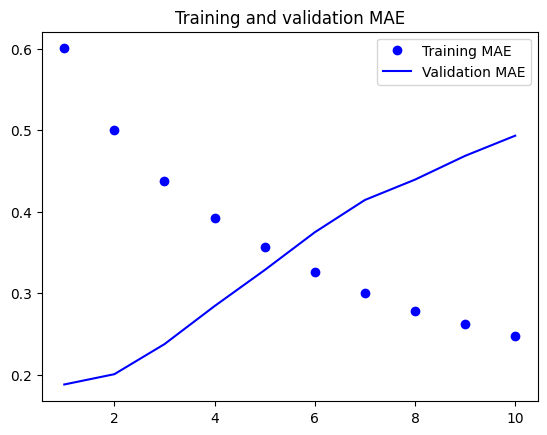

T-statistic: 0.5374164264495485
P-value: 0.5975642505521785
Fail to reject the null hypothesis. There is no significant difference between the distributions.


In [22]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

from scipy import stats


# Perform a t-test assuming unequal variances (Welch's t-test)
t_statistic, p_value = stats.ttest_ind(loss, val_loss, equal_var=False)

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the distributions.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the distributions.")


In [23]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

In [24]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

In [25]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


In [26]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


In [27]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## LSTM with Dropout

In [28]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("v3_lstm_dropout.tf",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
2/2 [==============================] - ETA: 0s - loss: 0.4407 - mae: 0.5331INFO:tensorflow:Assets written to: v3_lstm_dropout.tf\assets


INFO:tensorflow:Assets written to: v3_lstm_dropout.tf\assets


2/2 [==============================] - 5s 3s/step - loss: 0.4407 - mae: 0.5331 - val_loss: 0.2450 - val_mae: 0.4306
Epoch 2/10
2/2 [==============================] - 1s 579ms/step - loss: 0.3678 - mae: 0.4870 - val_loss: 0.2832 - val_mae: 0.4737
Epoch 3/10
2/2 [==============================] - ETA: 0s - loss: 0.2879 - mae: 0.4256INFO:tensorflow:Assets written to: v3_lstm_dropout.tf\assets


INFO:tensorflow:Assets written to: v3_lstm_dropout.tf\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2879 - mae: 0.4256 - val_loss: 0.2130 - val_mae: 0.3921
Epoch 4/10
2/2 [==============================] - 1s 583ms/step - loss: 0.2375 - mae: 0.3810 - val_loss: 0.2375 - val_mae: 0.4224
Epoch 5/10
2/2 [==============================] - 1s 633ms/step - loss: 0.2107 - mae: 0.3621 - val_loss: 0.2635 - val_mae: 0.4515
Epoch 6/10
2/2 [==============================] - 1s 555ms/step - loss: 0.2095 - mae: 0.3646 - val_loss: 0.2292 - val_mae: 0.4106
Epoch 7/10
2/2 [==============================] - 1s 516ms/step - loss: 0.1654 - mae: 0.3338 - val_loss: 0.3027 - val_mae: 0.4916
Epoch 8/10
2/2 [==============================] - 1s 523ms/step - loss: 0.1435 - mae: 0.3047 - val_loss: 0.2200 - val_mae: 0.3980
Epoch 9/10
2/2 [==============================] - 1s 544ms/step - loss: 0.1423 - mae: 0.3077 - val_loss: 0.3039 - val_mae: 0.4914
Epoch 10/10
2/2 [==============================] - 1s 518ms/step - loss: 0.1449 - mae: 0.3059 - val_loss

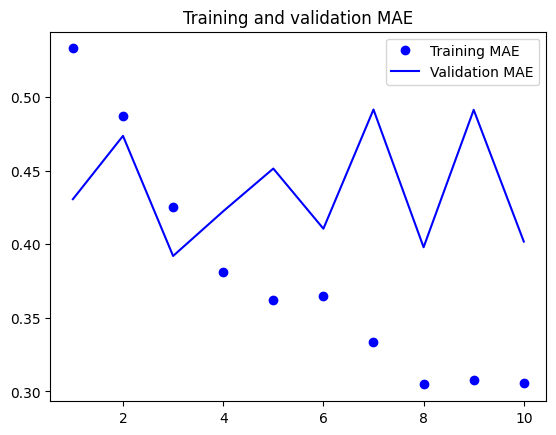

T-statistic: -2.011873944659658
P-value: 0.06539856775826515
Fail to reject the null hypothesis. There is no significant difference between the distributions.


In [29]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

from scipy import stats


# Perform a t-test assuming unequal variances (Welch's t-test)
t_statistic, p_value = stats.ttest_ind(loss, val_loss, equal_var=False)

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the distributions.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the distributions.")


In [30]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)


## GRU

In [31]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("v3_stacked_gru_dropout.tf",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("v3_stacked_gru_dropout.tf")
#print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
2/2 [==============================] - ETA: 0s - loss: 0.3590 - mae: 0.4659INFO:tensorflow:Assets written to: v3_stacked_gru_dropout.tf\assets


INFO:tensorflow:Assets written to: v3_stacked_gru_dropout.tf\assets


2/2 [==============================] - 10s 6s/step - loss: 0.3590 - mae: 0.4659 - val_loss: 0.0788 - val_mae: 0.2391
Epoch 2/10
2/2 [==============================] - 2s 930ms/step - loss: 0.2541 - mae: 0.3816 - val_loss: 0.0849 - val_mae: 0.2463
Epoch 3/10
2/2 [==============================] - 2s 1s/step - loss: 0.2016 - mae: 0.3498 - val_loss: 0.1974 - val_mae: 0.3705
Epoch 4/10
2/2 [==============================] - 2s 1s/step - loss: 0.1761 - mae: 0.3226 - val_loss: 0.1259 - val_mae: 0.2890
Epoch 5/10
2/2 [==============================] - 2s 1s/step - loss: 0.1618 - mae: 0.3047 - val_loss: 0.0993 - val_mae: 0.2608
Epoch 6/10
2/2 [==============================] - 2s 1s/step - loss: 0.1375 - mae: 0.2852 - val_loss: 0.0917 - val_mae: 0.2533
Epoch 7/10
2/2 [==============================] - 2s 1s/step - loss: 0.1242 - mae: 0.2755 - val_loss: 0.0790 - val_mae: 0.2386
Epoch 8/10
2/2 [==============================] - 2s 1s/step - loss: 0.1149 - mae: 0.2653 - val_loss: 0.1743 - val_mae

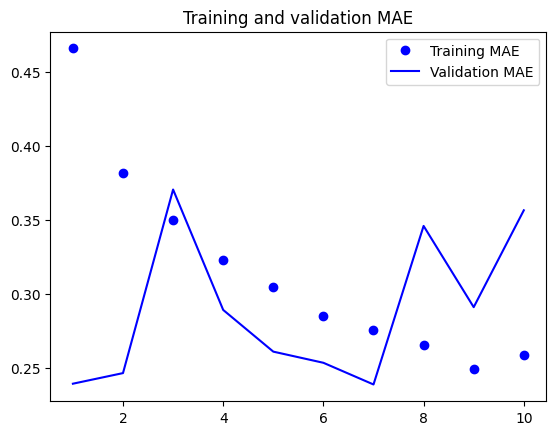

T-statistic: 0.9983412939330907
P-value: 0.33233328894990755
Fail to reject the null hypothesis. There is no significant difference between the distributions.


In [32]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

from scipy import stats


# Perform a t-test assuming unequal variances (Welch's t-test)
t_statistic, p_value = stats.ttest_ind(loss, val_loss, equal_var=False)

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the distributions.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the distributions.")
